# Urban Nature Access Calculation - Monte Carlo Simulations

The model for urban nature access provides a measure of both the supply of urban nature and the demand for nature by the urban population, ultimately calculating the balance between supply and demand.Supply is determined by the type, size, proximity, and quality of urban nature that is accessible per capita for recreational purposes. Demand is determined as natural space per capita, as typically required by policy or standards.

InVEST model calculates urban nature access on the basis of each pixel. In this study, the model has been modified to calculate on a subcatchment basis. Here, a method has been proposed to replicate the pixel-based model on a subcatchment level. This was done in order to facilate the Monte Carlo simulations where locations of LIDs in each scenario is not fixed to one pixel, but rather is allocated as a percentage to a subcatchment.

Green roofs have been excluded from this analysis because they are often not accessible to public. Nature access is calculated for LIDs- bioretention cell (BC), normal grass (GS), and trees (TRE). The benefit to public access for these three LIDs are different, therefore specific weights were assumed such as: "BC": 0.8, "GS": 0.7, "TRE": 1.0. 

In InVEST model, accessible urban nature is calculated as the total area of urban nature accessible to a pixel:
$$
accessible_i = \sum_{j=\{d_{ij} \leq d_0\}} S_j \cdot f(d_{ij})
$$

People use nature that are at a lesser distance than farther ones. So this model includes a distance decay function f(dij). Here a Gaussian decay function where likelihood to visit far places decreases according to a normal distribution.

$$
f(d_{ij}, d_0) =
\begin{cases}
\frac{e^{-\frac{1}{2} \left( \frac{d_{ij}}{d_0} \right)^2} - e^{-\frac{1}{2}}}{1 - e^{-\frac{1}{2}}} & \text{if } d_{ij} \leq d_0 \\
0 & \text{if } d_{ij} > d_0
\end{cases}
$$

Simply put, this model applies the following methods:

1. Extract centroids from subcatchment polygons.  
2. Compute a centroid-to-centroid distance matrix.  
3. For each scenario (row in CSV), compute weighted nature area per subcatchment.  
4. For each subcatchment *i*, compute accessible green space using Gaussian decay from all *j*s with urban nature.  
5. Save results in a CSV table, with per-subcatchment and mean UNA scores.

Note that the UNA scores obtained are not the absolute value. Since this model does not consider existing nature but only the addition of LIDs, this model determines the marginal gain of UNA. 

In [1]:
import arcpy
import pandas as pd
import numpy as np
from arcpy import env
from arcpy.sa import *

In [2]:
## Settings
env.workspace = r"C:\Users\ABI\OneDrive - NIVA\Documents\GitHub\SWMM_MOO\GIS_Input_Files\LorenGIS.gdb"  
arcpy.env.overwriteOutput = True
search_radius = 100  # meters
lid_csv_path = r"C:\Users\ABI\OneDrive - NIVA\Documents\GitHub\SWMM_MOO\01_Preprocessing\0103_Data_cleaned_random_generated_scenarios.csv"
shapefile_path = r"C:\Users\ABI\OneDrive - NIVA\Documents\GitHub\SWMM_MOO\GIS_Input_Files\Shapefiles\subcatchments_bdry.shp"
lid_df = pd.read_csv(lid_csv_path, delimiter=';')

The distance between subcatchements is determined from centroid to centroid. Therefore, a centroid matrix is created representing centroids between each subcatchments.

In [3]:
### Creating a distance matrix between each subcatchments and calculating a decay function raster

# Creating a dictionary with centroids of all subcatchments
subcat_fc = shapefile_path

# Get centroid coordinates
centroid_dict = {}      # a dictionary to save all coordinates 
with arcpy.da.SearchCursor(shapefile_path, ["SID", "SHAPE@XY"]) as cursor:    #SHAPE@XY returns centroids of polygons
    for sid, xy in cursor:
        sid_num = int(sid.replace("S", ""))  # Convert 'S5' → 5
        centroid_dict[sid_num] = xy
        
subcat_ids = list(centroid_dict.keys())
print("Centroid Dict Keys:", centroid_dict.keys())
print(centroid_dict)


Centroid Dict Keys: dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
{1: (265109.48665176687, 6651152.107425284), 2: (265063.2230072711, 6651138.245500137), 3: (265110.6102291129, 6651107.023762066), 4: (265068.5943896611, 6651090.039791075), 5: (265072.29026766913, 6651131.802824572), 6: (265087.25284361135, 6651121.816642927), 7: (265101.35299997835, 6651112.66593823), 8: (265085.9086564888, 6651152.710708944), 9: (265117.946130992, 6651131.682143776), 10: (265060.36631795694, 6651109.66183083), 11: (265091.2825118474, 6651089.592957335)}


In [4]:
# Now, after getting a dictionary with centroids of all subcatchements, a distance matrix between 
# the centroids is created.
distance_matrix = pd.DataFrame(index=subcat_ids, columns=subcat_ids, dtype=float)

for i in subcat_ids:
    for j in subcat_ids:
        xi, yi = centroid_dict[i]
        xj, yj = centroid_dict[j]
        d = ((xi - xj) ** 2 + (yi - yj) ** 2) ** 0.5
        distance_matrix.loc[i, j] = d
        
print(distance_matrix.round(2))

       1      2      3      4      5      6      7      8      9      10     11
1    0.00  48.30  45.10  74.33  42.38  37.57  40.27  23.59  22.11  64.92  65.11
2   48.30   0.00  56.75  48.50  11.12  29.11  45.92  26.91  55.12  28.73  56.16
3   45.10  56.75   0.00  45.32  45.63  27.65  10.84  51.94  25.73  50.31  26.03
4   74.33  48.50  45.32   0.00  41.93  36.85  39.81  65.02  64.57  21.28  22.69
5   42.38  11.12  45.63  41.93   0.00  17.99  34.80  24.95  45.66  25.15  46.29
6   37.57  29.11  27.65  36.85  17.99   0.00  16.81  30.92  32.24  29.51  32.47
7   40.27  45.92  10.84  39.81  34.80  16.81   0.00  42.92  25.24  41.10  25.17
8   23.59  26.91  51.94  65.02  24.95  30.92  42.92   0.00  38.32  50.06  63.35
9   22.11  55.12  25.73  64.57  45.66  32.24  25.24  38.32   0.00  61.65  49.82
10  64.92  28.73  50.31  21.28  25.15  29.51  41.10  50.06  61.65   0.00  36.86
11  65.11  56.16  26.03  22.69  46.29  32.47  25.17  63.35  49.82  36.86   0.00


In [5]:
### Load the csv file with all scenarios
lid_df = pd.read_csv(lid_csv_path, delimiter=';')

# Initializing
nature_weights = {"BC": 0.8, "GS": 0.7, "TRE": 1.0}  # assuming urban nature weights for each LID
lid_columns = ["S5", "S7", "S8", "S9", "S10", "S11"]
type_columns = ["S5_Type", "S7_Type", "S8_Type", "S9_Type", "S10_Type", "S11_Type"]
subcat_lookup = {"S5": 5, "S7": 7, "S8": 8, "S9": 9, "S10": 10, "S11": 11}

In [6]:
## Create a function for Gaussian decay function for the operation further
def gaussian_decay(d, d0):
    if d > d0:
        return 0
    return (np.exp(-0.5 * (d / d0)**2) - np.exp(-0.5)) / (1 - np.exp(-0.5))

In [7]:
### Calculating urban nature access score for each scenario

import numpy as np

una_results = []
subcat_ids = list(range(1, 12))

# Loop around each row for each LID scenario
for idx, row in lid_df.iterrows():
    
    # Loop through the terrain subcatchments S5, S7, S8, S9, S10, S11
    green_area = {}    # A dictionary to store all weighted area of urban nature in each subcatchment
    for lid_col, type_col in zip(lid_columns, type_columns):
        lid_type = row[type_col]
        if lid_type in nature_weights:
            sid = subcat_lookup[lid_col]                # Extracting integer for using it for distance matrix
            weight = nature_weights[lid_type]
            green_area[sid] = row[lid_col] * weight     # Multiplies area of new LID with respective weight
   # Now applying a Gaussian decay to calculate UNA
    access_scores = {}
    for i in subcat_ids:
        total = 0
        for j, S_j in green_area.items():
            if j in subcat_ids:
                d = distance_matrix.loc[i, j]
                if d <= search_radius:
                    # Gaussian decay (normalized)
                    decay = gaussian_decay(d, search_radius)
                    total += S_j * decay
        access_scores[i] = total
    una_results.append(access_scores)
   


In [8]:
# === STEP 5: Save output as table ===
una_df = pd.DataFrame(una_results)
una_df.index.name = "Sim"
una_df['Mean'] = una_df.mean(axis=1)   # Finding the average UNA in the whole study area

output_path = r"C:\Users\ABI\OneDrive - NIVA\Documents\GitHub\SWMM_MOO\05_Urban_Nature_Access\0502_UNA_results_per_scenario.csv"
una_df.to_csv(output_path, sep=';')

print(f"UNA scores saved to: {output_path}")
print(una_df.head())

UNA scores saved to: C:\Users\ABI\OneDrive - NIVA\Documents\GitHub\SWMM_MOO\05_Urban_Nature_Access\0502_UNA_results_per_scenario.csv
             1           2           3  ...         10         11        Mean
Sim                                     ...                                  
0     5.472172    6.890285    5.240812  ...   6.446263   5.192824    6.009882
1    99.244208  101.175836  101.634902  ...  96.225928  93.512744  101.387145
2    44.709282   42.923882   39.281270  ...  36.803943  33.316343   40.992667
3    53.018471   52.349609   64.411622  ...  55.732054  61.419076   58.734158
4    80.957046   95.611254   84.641437  ...  93.473653  83.408430   89.894653

[5 rows x 12 columns]


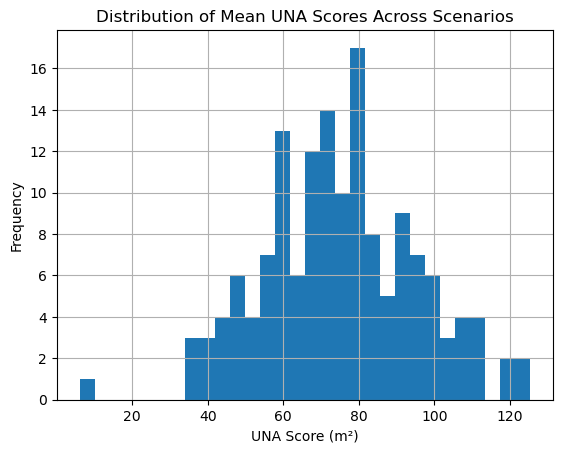

In [10]:
## Plot of histogram showing the values of UNA in m2 accross scenarios
%matplotlib inline
import matplotlib.pyplot as plt
una_df['Mean'].hist(bins=30)
plt.title('Distribution of Mean UNA Scores Across Scenarios')
plt.xlabel('UNA Score (m²)')
plt.ylabel('Frequency')
plt.savefig(r"C:\Users\ABI\OneDrive - NIVA\Documents\GitHub\SWMM_MOO\05_Urban_Nature_Access\0502_UNA_Results\0502_una_histogram.png", dpi=300)
plt.show()